In [32]:
import pandas as pd
import numpy as np
from sqlalchemy.dialects.mssql.information_schema import columns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../cleandata/processed_data.csv')
y = np.log(df['adjusted'] / df['adjusted'].shift(1)).dropna()

df.head()

,date,vix,g_trends,bullish_surv,neutral_surv,bearish_surv,bull_bear_spread_surv,volume,adjusted,sma_20,...,macd_signal,bb_up,bb_dn,obv,stochrsi,adx,sentiment_negative,sentiment_neutral,sentiment_none,sentiment_positive
0,2011-12-01,27.410000,4.0,0.3304,0.2753,0.3942,-0.0638,15453000.0,2.173333,2.128633,...,3.557743,2.296586,2.028014,176965500.0,0.204331,39.285575,0.0,1.0,0.0,0.0
1,2011-12-02,27.520000,4.0,0.3304,0.2753,0.3942,-0.0638,12042000.0,2.220000,2.109700,...,3.404987,2.301726,2.028474,189007500.0,0.356966,39.688757,0.0,0.0,1.0,0.0
2,2011-12-05,27.840000,4.0,0.3304,0.2753,0.3942,-0.0638,17401500.0,2.294667,2.093533,...,3.338467,2.319787,2.024480,206409000.0,0.576983,40.689184,0.0,0.0,1.0,0.0
3,2011-12-06,28.129999,4.0,0.3304,0.2753,0.3942,-0.0638,14277000.0,2.324667,2.080667,...,3.342544,2.340175,2.028092,220686000.0,0.658682,41.618152,0.0,0.0,1.0,0.0
4,2011-12-07,28.670000,4.0,0.3304,0.2753,0.3942,-0.0638,10114500.0,2.279333,2.065667,...,3.349141,2.350587,2.033346,210571500.0,0.661692,42.136144,0.0,0.0,1.0,0.0


In [33]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3347 entries, 0 to 3346
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   3347 non-null   object 
 1   vix                    3347 non-null   float64
 2   g_trends               3347 non-null   float64
 3   bullish_surv           3347 non-null   float64
 4   neutral_surv           3347 non-null   float64
 5   bearish_surv           3347 non-null   float64
 6   bull_bear_spread_surv  3347 non-null   float64
 7   volume                 3347 non-null   float64
 8   adjusted               3347 non-null   float64
 9   sma_20                 3347 non-null   float64
 10  sma_50                 3347 non-null   float64
 11  ema_20                 3347 non-null   float64
 12  basic_volatility       3347 non-null   float64
 13  atr                    3347 non-null   float64
 14  rsi                    3347 non-null   float64
 15  macd

,vix,g_trends,bullish_surv,neutral_surv,bearish_surv,bull_bear_spread_surv,volume,adjusted,sma_20,sma_50,...,macd_signal,bb_up,bb_dn,obv,stochrsi,adx,sentiment_negative,sentiment_neutral,sentiment_none,sentiment_positive
count,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3.347000e+03,3347.000000,3347.000000,3347.000000,...,3347.000000,3347.000000,3347.000000,3.347000e+03,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000
mean,17.667879,28.633702,0.352892,0.325772,0.321335,0.031557,1.047665e+08,94.426247,94.472011,94.466813,...,0.886130,105.941010,81.493058,8.784793e+09,0.506162,25.687086,0.016731,0.312817,0.621452,0.048999
std,6.613784,17.206135,0.084785,0.060460,0.087574,0.161431,7.650417e+07,113.827480,113.332822,112.442950,...,4.028596,128.492446,98.515616,6.996998e+09,0.372804,10.615574,0.128282,0.463710,0.485098,0.215898
min,9.140000,4.000000,0.158371,0.145038,0.150538,-0.431438,5.097000e+06,1.519333,1.823967,1.923587,...,-12.360630,1.933798,1.605034,-1.697550e+07,0.000000,8.617343,0.000000,0.000000,0.000000,0.000000
25%,13.360000,14.000000,0.289648,0.282923,0.256219,-0.080692,5.953345e+07,14.111334,14.287983,14.416867,...,-1.687627,15.532358,12.850899,3.887500e+09,0.137652,17.406287,0.000000,0.000000,0.000000,0.000000
50%,15.950000,25.000000,0.350211,0.320946,0.302158,0.045977,8.849100e+07,20.703333,20.866433,20.920387,...,0.588354,22.874490,18.618008,5.311206e+09,0.507958,23.487274,0.000000,0.000000,1.000000,0.000000
75%,20.145000,45.000000,0.416327,0.365759,0.373832,0.153409,1.270954e+08,199.098335,200.367500,206.467100,...,3.200737,224.949432,173.992525,1.643878e+10,0.886637,31.574525,0.000000,1.000000,1.000000,0.000000
max,82.690002,100.000000,0.597531,0.528600,0.608696,0.441975,9.140820e+08,479.859985,425.515999,402.026399,...,16.458286,494.109115,381.407834,2.241555e+10,1.000000,66.333314,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Distribuce sentiment proměnných')

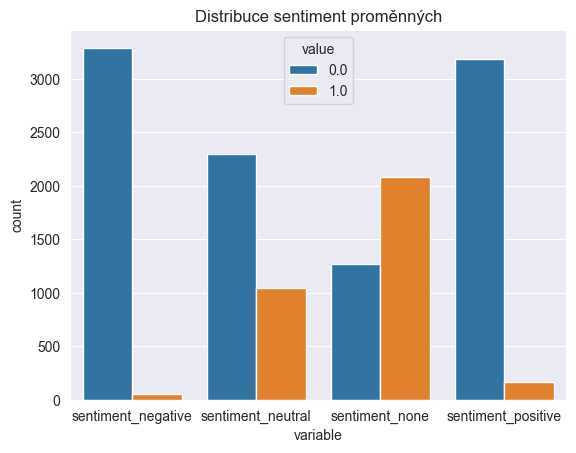

In [34]:
# převedeme do long formátu
df_long = df[["sentiment_negative", "sentiment_neutral", "sentiment_none", "sentiment_positive"]].melt(var_name='variable', value_name='value')

# vytvoříme countplot
sns.countplot(data=df_long, x='variable', hue='value')
plt.title("Distribuce sentiment proměnných")

Text(0, 0.5, 'Standardizovaná hodnota')

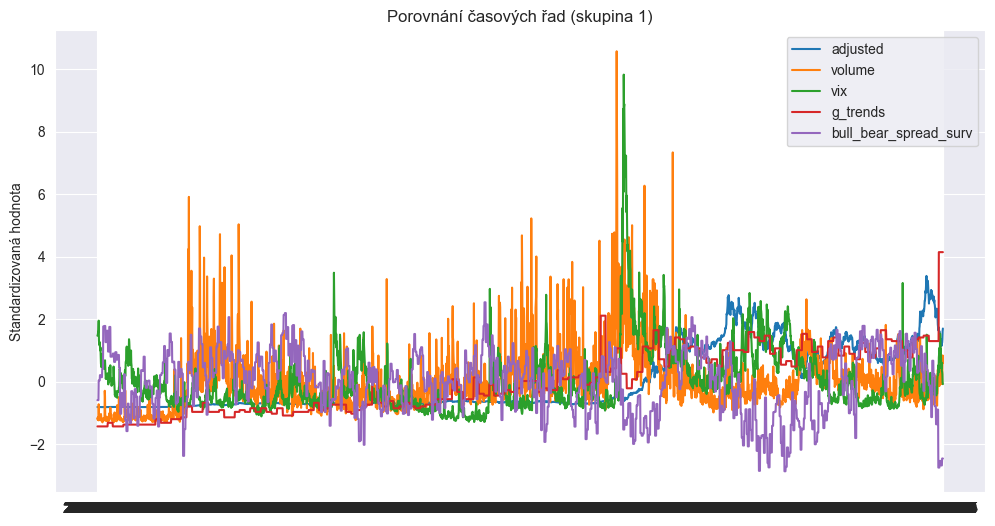

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

cols1 = ['adjusted', 'volume', 'vix', 'g_trends', 'bull_bear_spread_surv']
df_norm1 = df[cols1].apply(lambda x: (x - x.mean()) / x.std())
for col in cols1:
    ax.plot(df['date'], df_norm1[col], label=col)
ax.legend()
ax.set_title('Porovnání časových řad (skupina 1)')
ax.set_ylabel('Standardizovaná hodnota')

Text(0, 0.5, 'Standardizovaná hodnota')

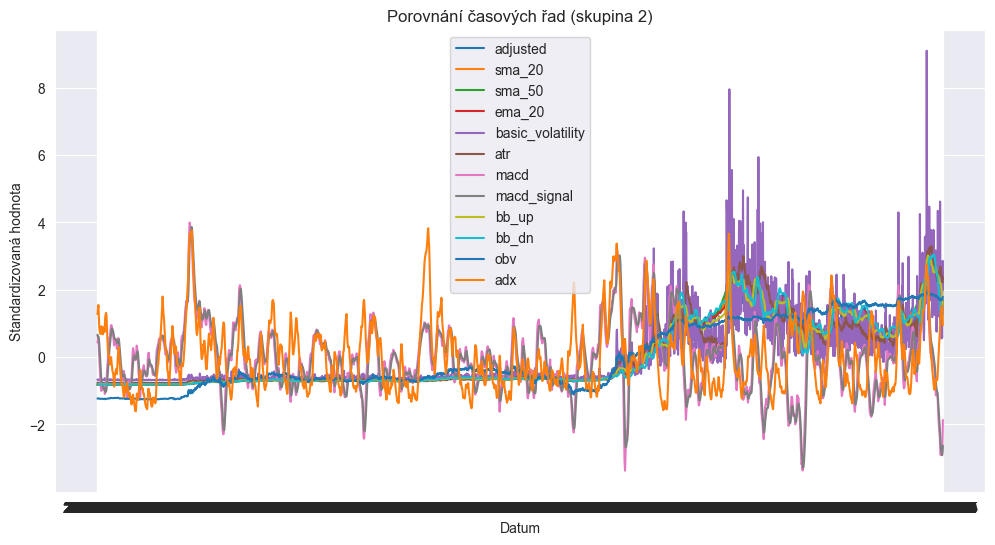

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

cols2 = ['adjusted', 'sma_20', 'sma_50', 'ema_20', 'basic_volatility', 'atr', 'macd', 'macd_signal', 'bb_up', 'bb_dn', 'obv', 'adx']
df_norm2 = df[cols2].apply(lambda x: (x - x.mean()) / x.std())
for col in cols2:
    ax.plot(df['date'], df_norm2[col], label=col)
ax.legend()
ax.set_title('Porovnání časových řad (skupina 2)')
ax.set_xlabel('Datum')
ax.set_ylabel('Standardizovaná hodnota')

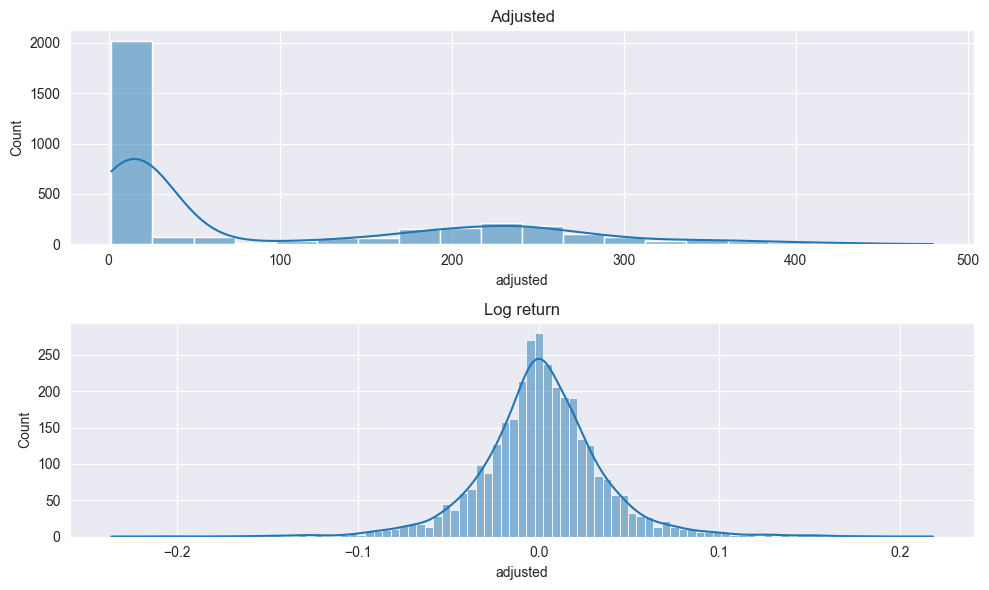

In [12]:
# distribuce predikovane y + v levels
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

sns.histplot(df["adjusted"],  kde=True, ax=ax[0])
ax[0].set_title("Adjusted")
sns.histplot(y, kde=True, ax=ax[1])
ax[1].set_title("Log return")

plt.tight_layout()

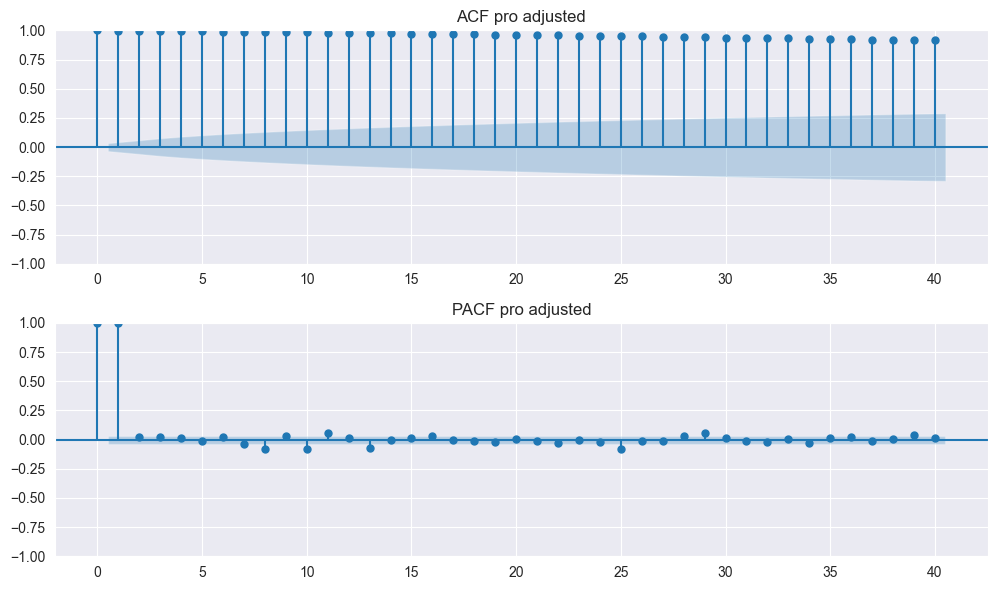

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ACF
plot_acf(df["adjusted"], ax=ax[0], lags=40)
ax[0].set_title(f"ACF pro adjusted")
# PACF
plot_pacf(df["adjusted"], ax=ax[1], lags=40)
ax[1].set_title(f"PACF pro adjusted")

plt.tight_layout()

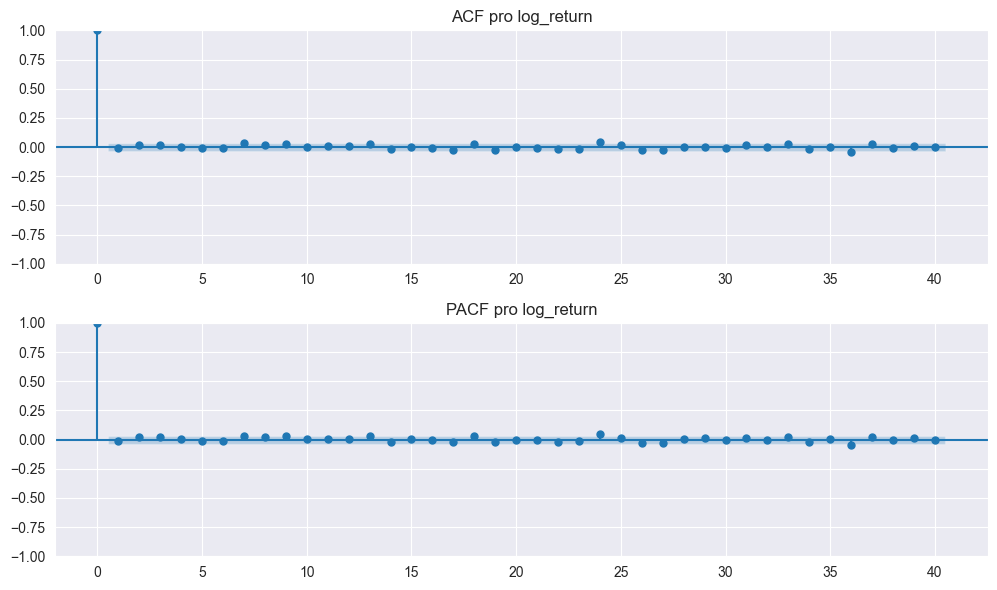

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ACF
plot_acf(y, ax=ax[0], lags=40)
ax[0].set_title(f"ACF pro log_return")
# PACF
plot_pacf(y, ax=ax[1], lags=40)
ax[1].set_title(f"PACF pro log_return")

plt.tight_layout()

<Axes: >

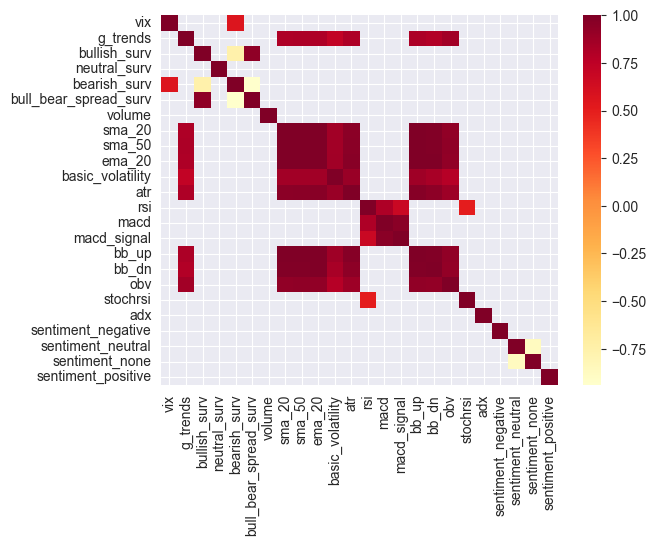

In [21]:
# Korelace features
# ukazuji pouze korelace > 0.5
mask = (df.drop(columns=["date", "adjusted"]).corr().abs() < 0.5)
sns.heatmap(df.drop(columns=["date", "adjusted"]).corr(), mask=mask, cmap="YlOrRd")


<Axes: >

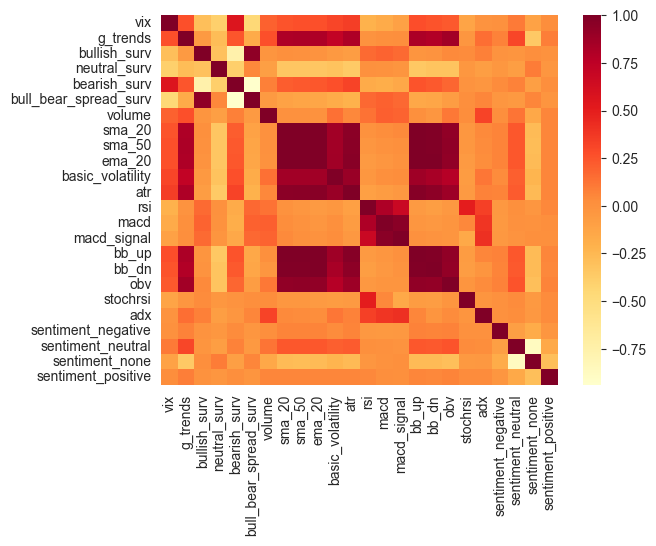

In [22]:
sns.heatmap(df.drop(columns=["date", "adjusted"]).corr(), cmap="YlOrRd")

vix_lag1                     -0.006462
vix_lag2                     -0.002787
sentiment_neutral_lag1        0.022815
sentiment_neutral_lag2        0.025426
sentiment_positive_lag1       0.012948
sentiment_positive_lag2      -0.000947
sentiment_negative_lag1      -0.015808
sentiment_negative_lag2       0.002772
g_trends_lag1                -0.000773
g_trends_lag2                -0.001755
bull_bear_spread_surv_lag1    0.005259
bull_bear_spread_surv_lag2    0.004450
volume_lag1                   0.034331
volume_lag2                   0.037057
sma_20_lag1                  -0.012671
sma_20_lag2                  -0.014951
sma_50_lag1                  -0.012564
sma_50_lag2                  -0.013490
ema_20_lag1                  -0.032238
ema_20_lag2                  -0.032458
basic_volatility_lag1        -0.024357
basic_volatility_lag2        -0.019813
atr_lag1                     -0.028896
atr_lag2                     -0.029737
rsi_lag1                      0.030799
rsi_lag2                 

<Axes: >

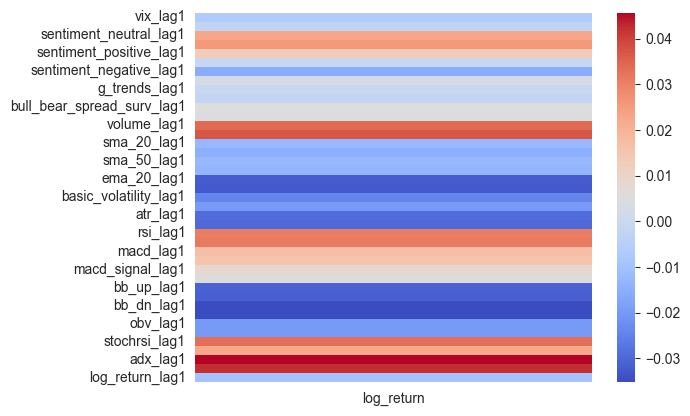

In [29]:
# Korelace kazde x (lag feature) s aktualni y (log return) -> potencialni predikcni sila

# vytvoreni X a y
features = [
    'vix', 'sentiment_neutral', 'sentiment_positive', 'sentiment_negative', 'g_trends',
    'bull_bear_spread_surv', 'volume', 'sma_20',
    'sma_50', 'ema_20', 'basic_volatility', 'atr', 'rsi', 'macd',
    'macd_signal', 'bb_up', 'bb_dn', 'obv', 'stochrsi', 'adx'
]

X = pd.DataFrame()
for col in features:
    X[col + '_lag1'] = df[col].shift(1)
    X[col + '_lag2'] = df[col].shift(2)

# log return
y = np.log(df['adjusted'] / df['adjusted'].shift(1))

X['log_return_lag1'] = y.shift(1)

# Drop 2 prvnich radku kvuli max lag = 2 a zarovnani indexu
X = X.dropna().reset_index(drop=True)
y = y.iloc[2:].reset_index(drop=True)

print(X.corrwith(y))
sns.heatmap(X.corrwith(y).to_frame(name="log_return"), cmap="coolwarm", cbar=True)

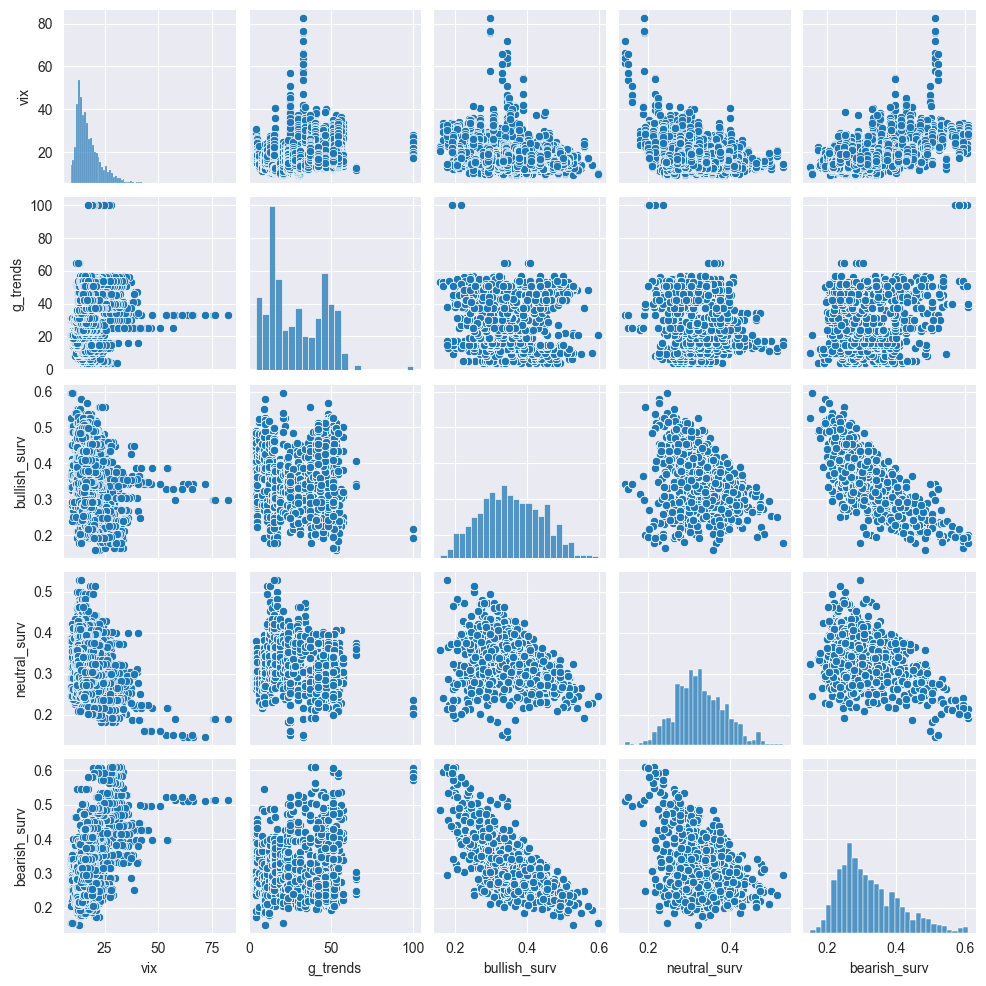

In [3]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[:5], height=2)

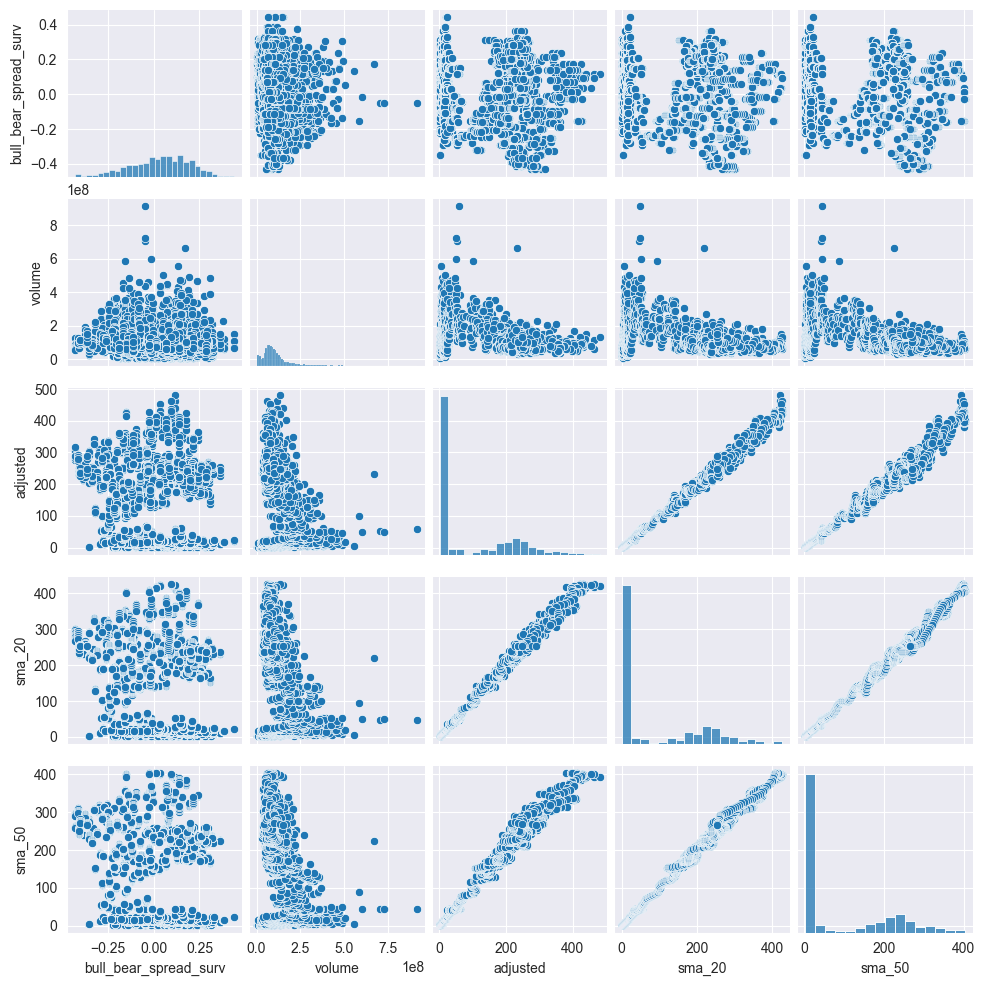

In [4]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[5:10], height=2)

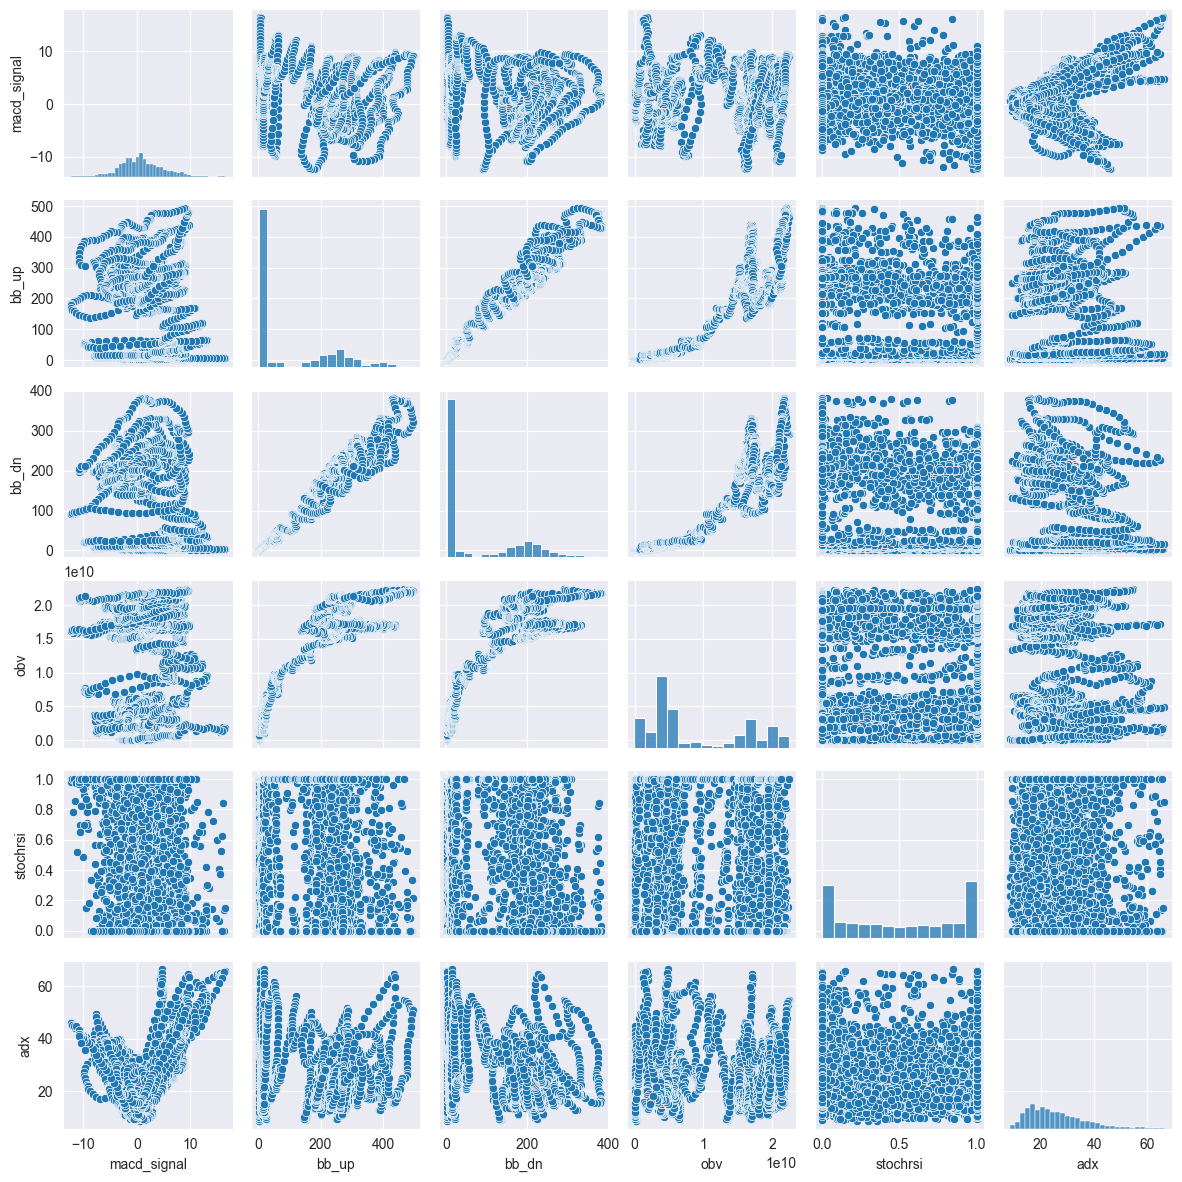

In [7]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[15:21], height=2)